In [108]:
import os

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from deepcell_tracking.metrics import calculate_summary_stats

In [109]:
baxter_path = '../benchmarking/Baxter/benchmarks.csv'
embedtrack_path = '../benchmarking/EmbedTrack/benchmarks.csv'
# deepcell_path = ''

In [160]:
# EmbedTrack data
et_df = pd.read_csv(embedtrack_path, index_col=0)
et_df['model'] = 'EmbedTrack ' + et_df['model']
et_df['gt-seg'] = False
# Rollup data for each model version
et_df = et_df.groupby('model').sum().drop(columns=['data_id']).reset_index()

In [194]:
# Baxter data
b_df = pd.read_csv(baxter_path, index_col=0)
b_df = b_df.sum().to_frame().T.drop(columns=['data_id'])
b_df['model'] = 'Baxter GT Seg'
b_df['gt-seg'] = True

In [195]:
# Deepcell data
dc = [{
    'model': 'DeepCell GT Seg',
    'gt-seg': True,
    'correct_division': 163,
    'mismatch_division': 7,
    'false_positive_division': 4,
    'false_negative_division': 8,
    'total_divisions': 178,
    'aa_tp': 47557,
    'aa_total': 48562,
    'te_tp': 48947,
    'te_total': 49775,
},
{
    'model': 'DeepCell',
    'gt-seg': False,
    'correct_division': 148,
    'mismatch_division': 17,
    'false_positive_division': 22,
    'false_negative_division': 13,
    'total_divisions': 178,
    'aa_tp': 46792,
    'aa_total': 48562,
    'te_tp': 48337,
    'te_total': 49775,
}]
dc_df = pd.DataFrame(dc)

# Plots

In [196]:
df = pd.concat([et_df, b_df, dc_df]).reset_index(drop=True)

In [197]:
df

,model,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total,gt-seg
0,EmbedTrack Fluo-N2DH-GOWT1,0,0,49,178,178,6189,49272,6616,50485,0
1,EmbedTrack Fluo-N2DH-SIM+,1,7,2247,170,178,23985,49272,25129,50485,0
2,EmbedTrack Fluo-N2DL-HeLa,113,9,455,56,178,43382,49272,44558,50485,0
3,Baxter GT Seg,111,7,22,60,178,48320,49272,49511,50485,1
4,DeepCell GT Seg,163,7,4,8,178,47557,48562,48947,49775,1
5,DeepCell,148,17,22,13,178,46792,48562,48337,49775,0


In [198]:
def calculate_stats(row):
    cols = ['correct_division', 'false_positive_division', 'false_negative_division', 'total_divisions',
            'aa_tp', 'aa_total', 'te_tp', 'te_total']
    d = row[cols].to_dict()
    return pd.Series(calculate_summary_stats(**d))

In [199]:
df = df.join(df.apply(calculate_stats, axis=1))

In [200]:
stats_columns = ['Division Precision', 'Division F1', 'Mitotic branching correctness', 'Association Accuracy',
       'Target Effectiveness']
stats = df[['model']+stats_columns].melt(
    id_vars='model',
    value_vars=stats_columns,
    var_name='metric'
    )
div_columns = ['correct_division', 'mismatch_division', 'false_positive_division', 'false_negative_division']
divisions = df[['model']+div_columns].melt(
    id_vars='model',
    value_vars=div_columns,
    var_name='metric'
    )

In [206]:
# Norm for tab20 colormap
norm = Normalize(vmin=0, vmax=19)

# GT segs are even numbers
colors = {
    'Baxter GT Seg': cm.tab20(norm(0)),
    'DeepCell GT Seg': cm.tab20(norm(2)),
    'DeepCell': cm.tab20(norm(3)),
    'EmbedTrack Fluo-N2DH-GOWT1': cm.tab20(norm(5)),
    'EmbedTrack Fluo-N2DH-SIM+': cm.tab20(norm(7)),
    'EmbedTrack Fluo-N2DL-HeLa': cm.tab20(norm(9))
}

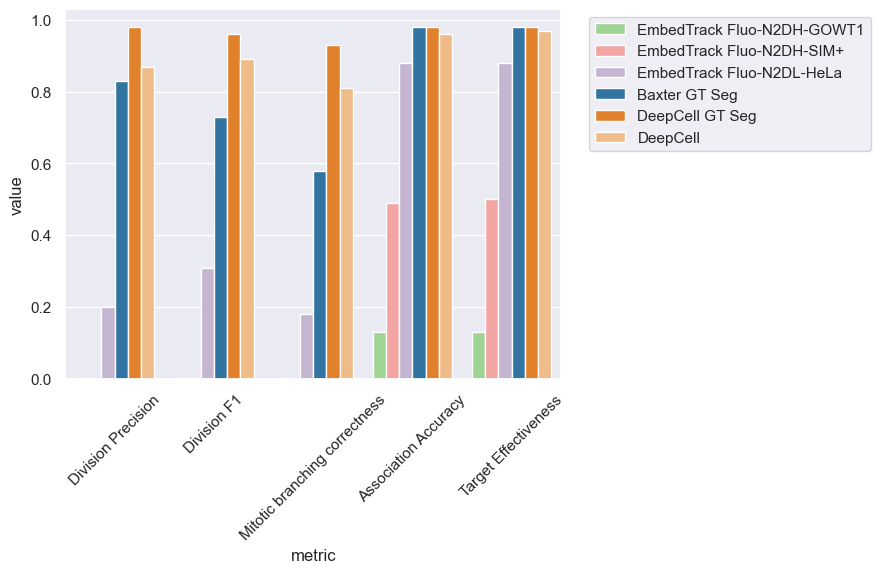

In [207]:
sns.barplot(
    data=stats,
    x='metric',
    y='value',
    hue='model',
    palette=colors
)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")